Financial Risk Data - Large
src : https://www.kaggle.com/datasets/deboleenamukherjee/financial-risk-data-large
columns : 51 columns

In [1]:
!pip install pip==23.2.1 setuptools==65.5.1

In [2]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [3]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "financial_risk_analysis_large.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/financial_risk_analysis_large.csv


In [4]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [5]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,CreditScore,AnnualIncome,LoanAmount,LoanDuration,Age,EmploymentStatus,MaritalStatus,NumberOfDependents,EducationLevel,HomeOwnershipStatus,...,JobTenure,MonthlySavings,AnnualBonuses,AnnualExpenses,MonthlyHousingCosts,MonthlyTransportationCosts,MonthlyFoodCosts,MonthlyHealthcareCosts,MonthlyEntertainmentCosts,LoanApproved
0,402,63295,18830,13,29,Self-Employed,Widowed,2,Doctorate,Other,...,24,378,3741,40058,977,412,399,136,124,0
1,735,55936,23729,1,42,Self-Employed,Divorced,3,Master,Own,...,10,575,4115,16745,695,206,898,252,131,0
2,570,62547,19660,7,54,Self-Employed,Single,3,Doctorate,Mortgage,...,16,691,4105,23273,627,266,392,73,36,0
3,406,46129,21674,23,25,Self-Employed,Divorced,3,High School,Other,...,6,452,4559,42163,397,307,250,378,-32,0
4,371,57725,12189,26,42,Employed,Widowed,4,Master,Own,...,2,690,7856,30087,723,315,114,88,68,0


In [6]:
df.shape

(1000000, 51)

In [7]:
df.columns

Index(['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age',
       'EmploymentStatus', 'MaritalStatus', 'NumberOfDependents',
       'EducationLevel', 'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'InterestRate', 'PaymentHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance',
       'InvestmentAccountBalance', 'RetirementAccountBalance',
       'EmergencyFundBalance', 'TotalAssets', 'TotalLiabilities', 'NetWorth',
       'LengthOfCreditHistory', 'MortgageBalance', 'RentPayments',
       'AutoLoanBalance', 'PersonalLoanBalance', 'StudentLoanBalance',
       'UtilityBillsPaymentHistory', 'HealthInsuranceStatus',
       'LifeInsuranceStatus', 'CarInsuranceStatus', 'HomeInsuranceStatus',
       'OtherInsurancePolicies', 'EmployerType', 'JobTenure', 'MonthlySavings',
       'AnnualB

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CreditScore                 1000000 non-null  int64  
 1   AnnualIncome                1000000 non-null  int64  
 2   LoanAmount                  1000000 non-null  int64  
 3   LoanDuration                1000000 non-null  int64  
 4   Age                         1000000 non-null  int64  
 5   EmploymentStatus            1000000 non-null  object 
 6   MaritalStatus               1000000 non-null  object 
 7   NumberOfDependents          1000000 non-null  int64  
 8   EducationLevel              1000000 non-null  object 
 9   HomeOwnershipStatus         1000000 non-null  object 
 10  MonthlyDebtPayments         1000000 non-null  int64  
 11  CreditCardUtilizationRate   1000000 non-null  float64
 12  NumberOfOpenCreditLines     1000000 non-null  int64  
 13

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

CreditScore                   0
AnnualIncome                  0
LoanAmount                    0
LoanDuration                  0
Age                           0
EmploymentStatus              0
MaritalStatus                 0
NumberOfDependents            0
EducationLevel                0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
InterestRate                  0
PaymentHistory                0
SavingsAccountBalance         0
CheckingAccountBalance        0
InvestmentAccountBalance      0
RetirementAccountBalance      0
EmergencyFundBalance          0
TotalAssets                   0
TotalLiabilities              0
NetWorth                      0
LengthOfCreditHistory         0
MortgageBalance               0
RentPayments                  0
AutoLoan

In [11]:
df["LoanApproved"].value_counts()
df["LoanApproved"].value_counts(normalize=True) * 100

0    62.6831
1    37.3169
Name: LoanApproved, dtype: float64

/tmp/ipykernel_17658/3160062249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="LoanApproved", data=df, palette="Set2")


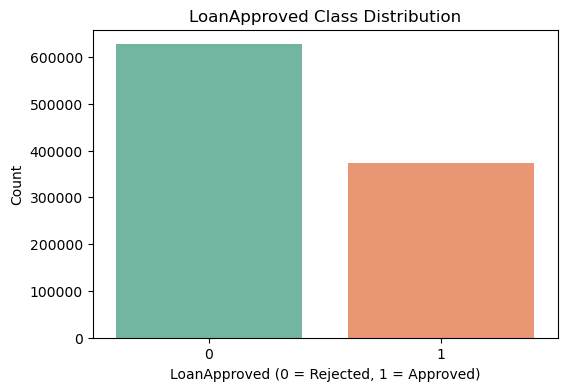

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x="LoanApproved", data=df, palette="Set2")
plt.title("LoanApproved Class Distribution")
plt.xlabel("LoanApproved (0 = Rejected, 1 = Approved)")
plt.ylabel("Count")
plt.show()

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separate features and target
X = df.drop("LoanApproved", axis=1)
y = df["LoanApproved"]

# Initialize undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_res, y_res = rus.fit_resample(X, y)

# Check new class distribution
print("Original:", Counter(y))
print("Resampled:", Counter(y_res))


Original: Counter({0: 626831, 1: 373169})
Resampled: Counter({0: 373169, 1: 373169})


In [14]:
# Get unique values and their counts in the resampled target variable (y_res)
unique_y_res_counts = y_res.value_counts()
print("Unique values and counts in y_res:\n", unique_y_res_counts)

# Get unique values and their counts for each feature in the resampled features (X_res)
unique_X_res_counts = {}
for column in X_res.columns:
    unique_X_res_counts[column] = X_res[column].value_counts()

# Check unique values and counts in each column of X_res
for column, value_counts in unique_X_res_counts.items():
    print(f"Unique values and counts in {column}:\n {value_counts.head()}")  # Showing only the first 5 for brevity


Unique values and counts in y_res:
 0    373169
1    373169
Name: LoanApproved, dtype: int64
Unique values and counts in CreditScore:
 508    1621
577    1608
521    1607
678    1606
813    1597
Name: CreditScore, dtype: int64
Unique values and counts in AnnualIncome:
 60336    37
53002    37
56793    36
57654    36
64235    35
Name: AnnualIncome, dtype: int64
Unique values and counts in LoanAmount:
 19143    92
17908    87
20453    87
18540    86
19079    84
Name: LoanAmount, dtype: int64
Unique values and counts in LoanDuration:
 21    26208
18    26034
28    26016
29    25981
10    25945
Name: LoanDuration, dtype: int64
Unique values and counts in Age:
 38    14617
56    14615
64    14538
22    14532
60    14502
Name: Age, dtype: int64
Unique values and counts in EmploymentStatus:
 Unemployed       248990
Employed         248756
Self-Employed    248592
Name: EmploymentStatus, dtype: int64
Unique values and counts in MaritalStatus:
 Single      186972
Married     186790
Divorced    1

In [15]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd

# List of categorical columns
categorical_columns = ['EmploymentStatus', 'MaritalStatus', 'EducationLevel', 
                       'HomeOwnershipStatus', 'LoanPurpose', 'HealthInsuranceStatus', 
                       'LifeInsuranceStatus', 'CarInsuranceStatus', 'HomeInsuranceStatus', 
                       'EmployerType']

# Separate numerical columns (to avoid encoding them)
numerical_columns = X_res.select_dtypes(include=['int64', 'float64']).columns

# Step 1: Label encode the ordinal categorical columns (if any)
le = LabelEncoder()
# Apply label encoding only to ordinal columns (example: EmploymentStatus, EducationLevel)
for column in categorical_columns:
    if X_res[column].nunique() > 2:  # Assuming these are ordinal columns
        X_res[column] = le.fit_transform(X_res[column])

# Step 2: One-hot encode the categorical columns that are non-ordinal
X_res = pd.get_dummies(X_res, columns=categorical_columns, drop_first=True)

# Step 3: Scale only the numerical columns (excluding the already binary one-hot columns)
scaler = MinMaxScaler()
X_res[numerical_columns] = scaler.fit_transform(X_res[numerical_columns])

# Now the DataFrame X_res contains:
# - Label encoded ordinal columns
# - One-hot encoded nominal columns
# - Scaled numerical columns

# Print the first few rows of the transformed data
print(X_res.head())


        CreditScore  AnnualIncome  LoanAmount  LoanDuration       Age  \
428899     0.102004      0.466174    0.500311      0.857143  0.078431   
644855     0.010929      0.596368    0.427872      0.178571  0.647059   
582815     0.198543      0.672157    0.521206      0.285714  0.607843   
457302     0.930783      0.442870    0.605829      0.250000  0.411765   
890644     0.834244      0.323839    0.424801      0.321429  0.843137   

        NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
428899                0.75             0.421053                   0.724854   
644855                0.00             0.570175                   0.125667   
582815                0.75             0.425697                   0.665438   
457302                0.75             0.566047                   0.345216   
890644                0.00             0.549020                   0.741843   

        NumberOfOpenCreditLines  NumberOfCreditInquiries  ...  LoanPurpose_2  \
428899      

In [16]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Check the shape of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (597070, 63)
X_test shape: (149268, 63)
y_train shape: (597070,)
y_test shape: (149268,)


# FInd Algorithem = XGboot 40X

In [20]:
import time
import random
import math
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as pl

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [22]:
# DEAP setup for GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using XGBoost with GPU acceleration."""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1
    }

    dtrain = xgb.DMatrix(X_train.iloc[:, selected_indices], label=y_train)
    dtest = xgb.DMatrix(X_test.iloc[:, selected_indices], label=y_test)

    model = xgb.train(
        param, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    return mean_squared_error(y_test, model.predict(dtest))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [23]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm (Scaled: 60 whales, 40 iterations)"""
    def __init__(self, func, dim, lb, ub, n_whales=60, max_iter=40):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # Linearly decreases from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # Linearly decreases from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate and update best
                fitness[i] = self.func(whales[i])
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness


In [24]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and scaled to 60 players and 40 games."""
    def __init__(self, func, dim, lb, ub, n_players=60, max_games=40):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players and their roles (0 = defensive, 1 = offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])

        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.1 + (0.4 * game / self.max_games)  # Adjusted scaling  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    step = np.random.normal(0, 0.25 * (1 - game / self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # 10% chance to switch role
                if random.random() < 0.1:
                    roles[i] = 1 - roles[i]

            # Evaluate new population and apply survival conditions
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1 * best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness


In [25]:
class PSH_Hyptrite:
    """2x Scaled PSH with bounds checking and hypersphere sampling."""
    def __init__(self, func, dim, lb, ub, n_points=60, max_iter=40):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - (iter/self.max_iter)**0.5)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 5)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

In [26]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 60")
        print(f"- Generations: 40")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup evolutionary toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=5)

    # 3. Initialize population
    population = toolbox.population(n=60)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop with progress tracking
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(40):
        # Evolve population
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        # Update fitness
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Selection
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        # Record stats
        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        # Print progress every 5 generations
        if gen % 5 == 0 or gen == 39:
            print(f"Gen {gen+1:02d}/40 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence')
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [27]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 60 particles")  # Updated to 60 particles
        print(f"- Iterations: 40")  # Updated to 40 iterations
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 60 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=60,
        maxiter=40,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [28]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 60 whales")  # Updated to 60
        print(f"- Max iterations: 40")  # Updated to 40
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")
        
    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=60, max_iter=40):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)  # a decreases linearly 2→0
                a2 = -1 + iter * (-1 / self.max_iter)  # a2 decreases linearly -1→-2

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            # Encircling prey
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            # Search for prey
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        # Bubble-net attacking
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    # Boundary check
                    whales[i] = np.clip(whales[i], self.lb, self.ub)

                    # Evaluate new solution
                    fitness[i] = self.func(whales[i])

                    # Update best
                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=60,
        max_iter=40
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }


In [29]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 60 (30 offensive, 30 defensive)")  # Updated to 60 players
        print(f"- Max games: 40")  # Updated to 40 max games
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=60,
        max_games=40
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence')
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [30]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 60")
        print(f"- Max iterations: 40")
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite Implementation
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=60, max_iter=40):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3  # Hypersphere sampling points

        def hypersphere_sampling(self, center, radius, n_samples):
            """Generates points on hypersphere surface with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Avoid division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize search points
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                # Current adaptive radius
                radius = initial_radius * (1 - iter/self.max_iter)

                # Generate new points via hypersphere sampling
                new_points = []
                for p in points:
                    hs_points = self.hypersphere_sampling(p, radius, self.hs_samples)
                    new_points.extend(hs_points)
                new_points = np.array(new_points)

                # Evaluate new points
                new_fitness = np.array([self.func(p) for p in new_points])

                # Combine with previous points
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])

                # Select best n_points for next iteration
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]

                # Update global best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Run optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=60,
        max_iter=40
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-process results to ensure at least 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    if len(selected_indices) < 3:
        # Fallback to top 3 features by weight
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate with enforced features

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Convergence visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [31]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name}...")
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms"""
    plt.figure(figsize=(15, 10))

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'blue' for name in names]
    plt.bar(names, mses, color=colors)
    plt.title('Algorithm Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    plt.bar(names, times, color=colors)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    plt.bar(names, feature_counts, color=colors)
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=2 if name == best_algo_name else 1)
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"\n🏆 Best Algorithm: {best_algo_name}")
    print(f"📉 Best MSE Achieved: {results[best_algo_name]['mse']:.6f}")
    print(f"⏱️ Execution Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"🔢 Features Selected: {len(results[best_algo_name]['features'])}")
    print("\nSelected Features:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 60
- Generations: 40
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 63 features
- Target: Minimize MSE using XGBoost

[Evolution Progress]
Gen 01/40 | Best MSE: 0.143348 | Avg MSE: 0.147337
Gen 06/40 | Best MSE: 0.143320 | Avg MSE: 0.143333
Gen 11/40 | Best MSE: 0.143314 | Avg MSE: 0.143316
Gen 16/40 | Best MSE: 0.143314 | Avg MSE: 0.143314
Gen 21/40 | Best MSE: 0.143311 | Avg MSE: 0.143311
Gen 26/40 | Best MSE: 0.143311 | Avg MSE: 0.143311
Gen 31/40 | Best MSE: 0.143311 | Avg MSE: 0.143311
Gen 36/40 | Best MSE: 0.143311 | Avg MSE: 0.143311
Gen 40/40 | Best MSE: 0.143308 | Avg MSE: 0.143310

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143307
▶ Time elapsed: 1862.79 seconds
▶ Features selected: 28/63 (55.6% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. Age
4. NumberOfDependents
5. NumberOfCreditInquiries
6. DebtToIncomeRatio
7. BankruptcyHi

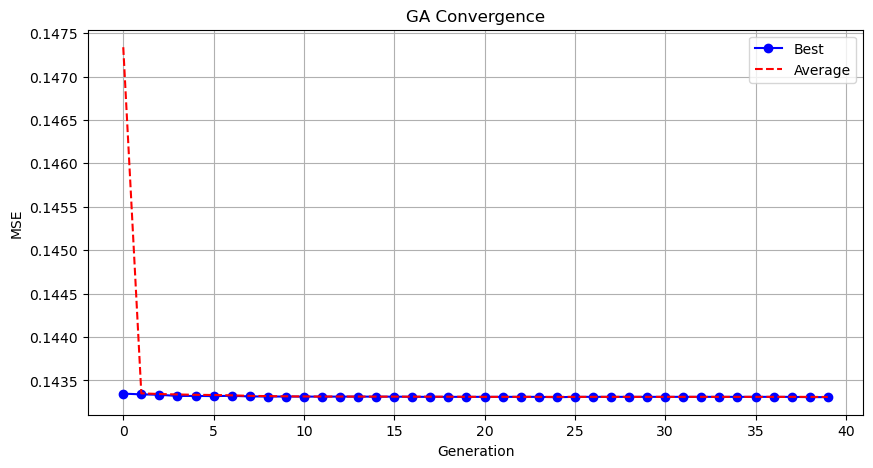

Genetic Algorithm completed successfully with MSE: 0.1433

Running Particle Swarm Optimization...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 60 particles
- Iterations: 40
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 63 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.245580
Best after iteration 1: [5.97570019e-01 8.00492480e-01 3.10137595e-01 6.52748113e-01
 1.29643596e-01 2.30131999e-01 7.76671375e-01 9.41294592e-01
 4.39928326e-04 8.19419504e-01 6.40753874e-02 4.43858601e-02
 2.17132635e-01 2.57799136e-01 9.34342228e-01 5.93801392e-01
 7.12468213e-01 4.03644693e-01 4.96665145e-01 1.96354359e-01
 9.61056313e-01 1.73820387e-01 3.16665307e-01 4.68985839e-01
 7.58198821e-01 7.19096307e-01 5.07507705e-01 4.74953638e-01
 7.92178052e-01 4.73664068e-01 8.91964720e-01 3.24878821e-01
 7.97079294e-01 9.24122798e-01 7.29080139e-01 1.73637846e-02
 7.45458832e-01 4.

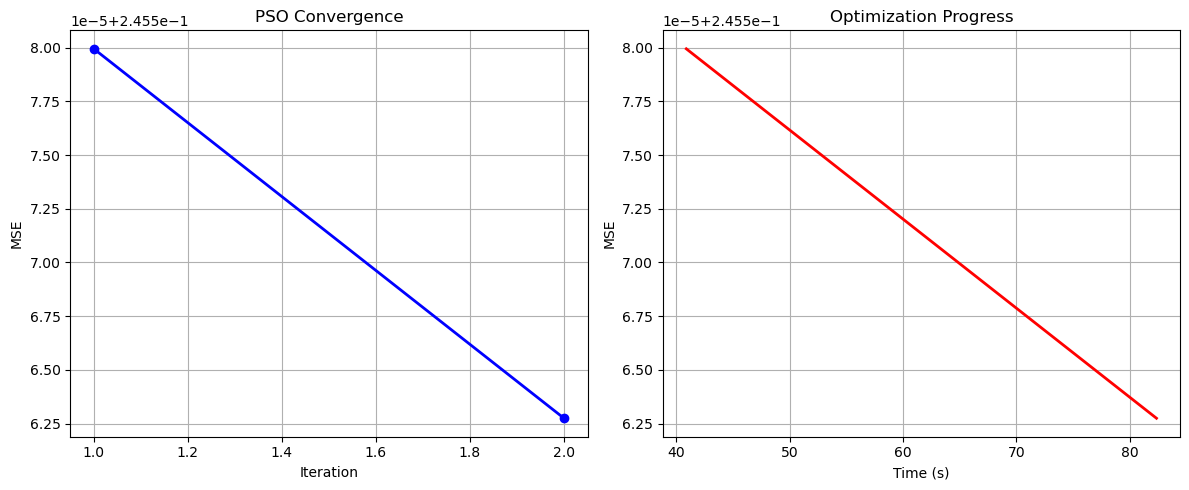

Particle Swarm Optimization completed successfully with MSE: 0.1433

Running Whale Optimization...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 60 whales
- Max iterations: 40
- Spiral coefficient (b): 1.0
- Search space: 63 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 40/40 | Best MSE: 0.143327

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143327
▶ Time elapsed: 1678.62 seconds
▶ Features selected: 28/63 (55.6% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. LoanDuration
4. NumberOfDependents
5. NumberOfCreditInquiries
6. DebtToIncomeRatio
7. BankruptcyHistory
8. PreviousLoanDefaults
9. PaymentHistory
10. SavingsAccountBalance
11. TotalLiabilities
12. RentPayments
13. AutoLoanBalance
14. PersonalLoanBalance
15. OtherInsurancePolicies
16. AnnualBonuses
17. AnnualExpenses
18. MonthlyHousingCosts
19. MonthlyTransportationCosts
20. MonthlyFoodCosts
21. MonthlyHealthcareCosts
22. EmploymentStatus_2
23. Marita

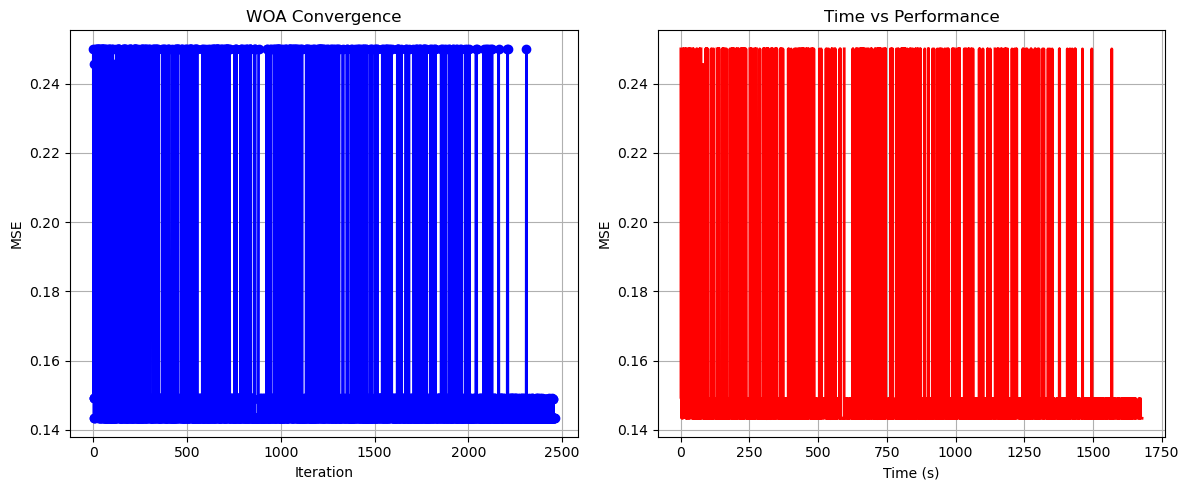

Whale Optimization completed successfully with MSE: 0.1433

Running Squid Game Optimizer...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 60 (30 offensive, 30 defensive)
- Max games: 40
- Search space: 63 features
- Target: Minimize MSE using XGBoost


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143316
▶ Time elapsed: 1651.88 seconds
▶ Features selected: 25/63 (60.3% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. PaymentHistory
4. SavingsAccountBalance
5. RetirementAccountBalance
6. EmergencyFundBalance
7. TotalLiabilities
8. MortgageBalance
9. RentPayments
10. PersonalLoanBalance
11. StudentLoanBalance
12. UtilityBillsPaymentHistory
13. OtherInsurancePolicies
14. JobTenure
15. AnnualBonuses
16. MonthlyTransportationCosts
17. MonthlyFoodCosts
18. EmploymentStatus_2
19. MaritalStatus_2
20. MaritalStatus_3
21. HomeOwnershipStatus_3
22. HealthInsuranceStatus_Uninsured
23. CarInsuranceStatus_Uninsured
24. EmployerType_1
25. EmployerType_2

▶ 

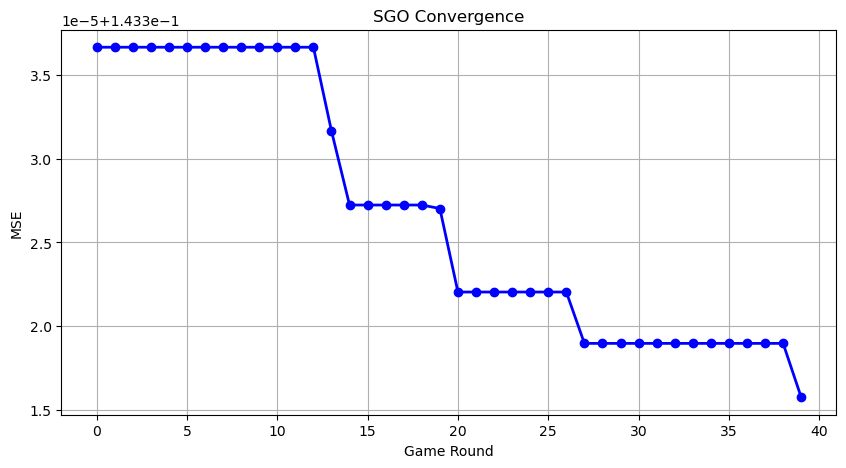

Squid Game Optimizer completed successfully with MSE: 0.1433

Running PSH-Hyptrite...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 60
- Max iterations: 40
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 63 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 40/40 | Best MSE: 0.143311 | Radius: 0.0125

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143311
▶ Time elapsed: 5746.67 seconds
▶ Features selected: 31/63 (50.8% reduction)

▶ Selected features (with weights):
1. CreditScore (weight: 0.663)
2. AnnualIncome (weight: 0.664)
3. Age (weight: 0.689)
4. CreditCardUtilizationRate (weight: 0.930)
5. NumberOfOpenCreditLines (weight: 0.543)
6. NumberOfCreditInquiries (weight: 0.710)
7. DebtToIncomeRatio (weight: 0.796)
8. BankruptcyHistory (weight: 0.722)
9. SavingsAccountBalance (weight: 0.551)
10. CheckingAccountBalance (weight: 0.954)
11. RetirementAccountBalance (weight: 0.514)
12. EmergencyFundB

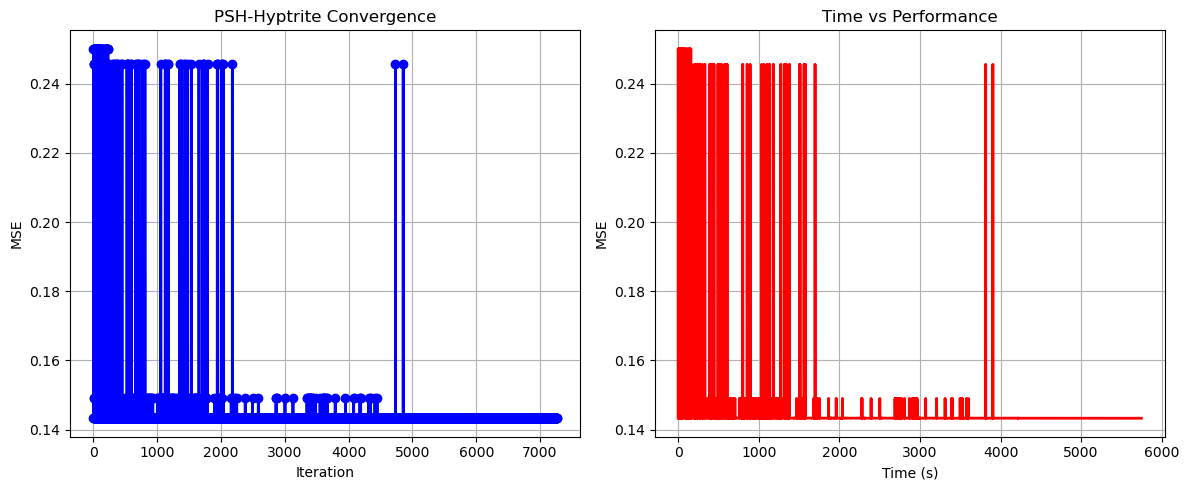

PSH-Hyptrite completed successfully with MSE: 0.1433


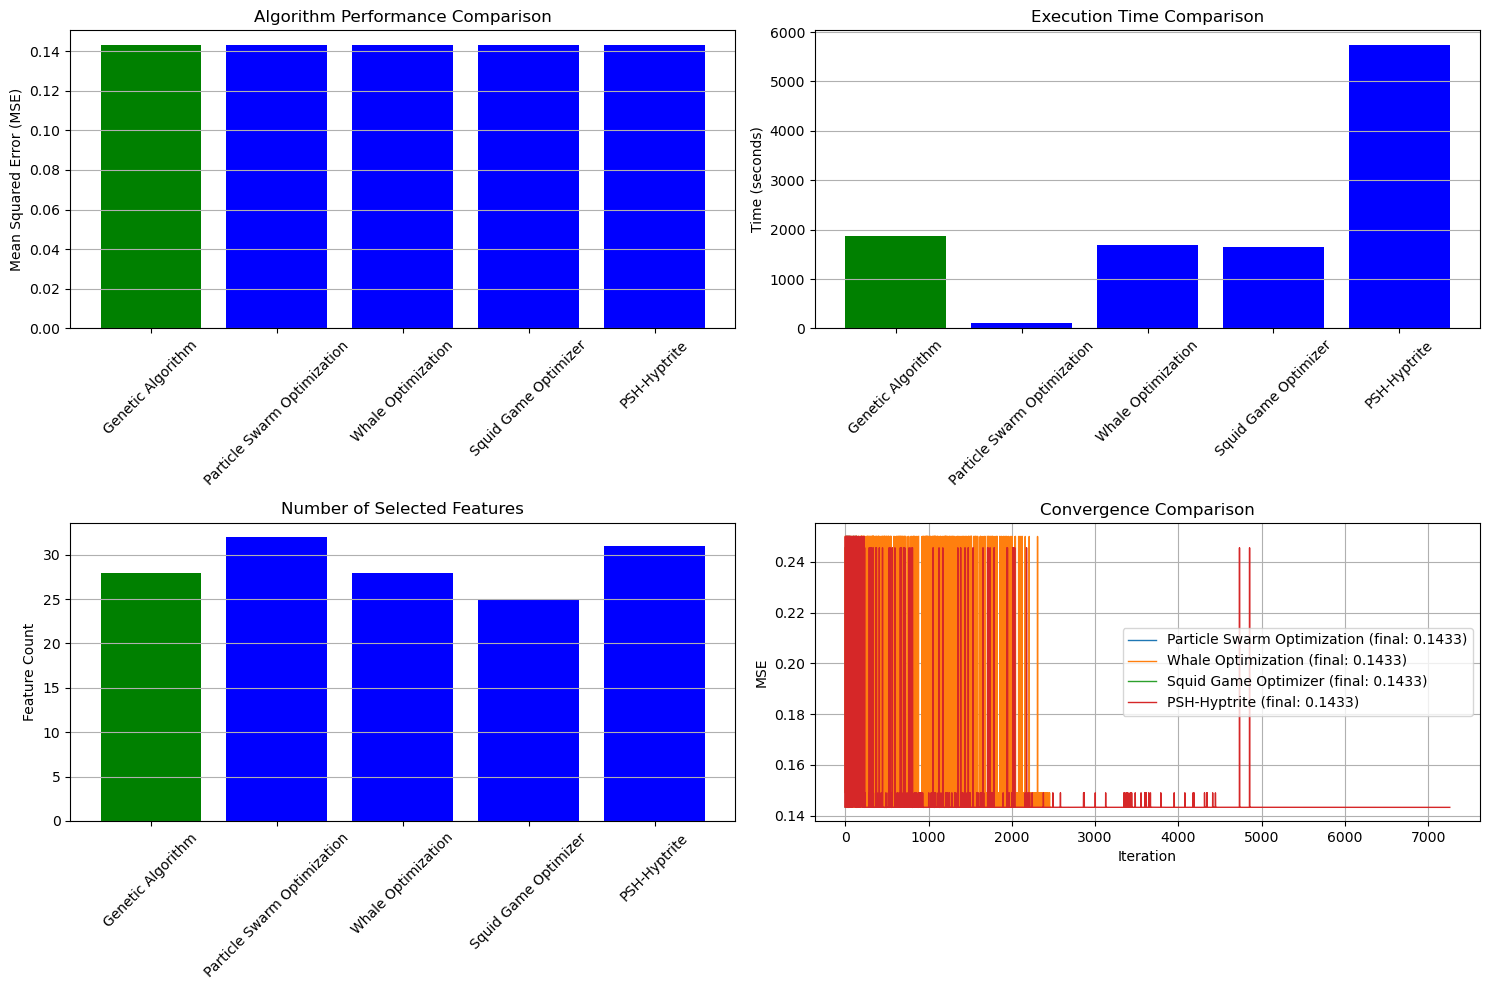


FINAL RESULTS SUMMARY

🏆 Best Algorithm: Genetic Algorithm
📉 Best MSE Achieved: 0.143307
⏱️ Execution Time: 1862.79 seconds
🔢 Features Selected: 28

Selected Features:
1. CreditScore
2. AnnualIncome
3. Age
4. NumberOfDependents
5. NumberOfCreditInquiries
6. DebtToIncomeRatio
7. BankruptcyHistory
8. CheckingAccountBalance
9. RetirementAccountBalance
10. EmergencyFundBalance
11. LengthOfCreditHistory
12. AutoLoanBalance
13. StudentLoanBalance
14. OtherInsurancePolicies
15. JobTenure
16. AnnualExpenses
17. MonthlyHousingCosts
18. MonthlyFoodCosts
19. MonthlyHealthcareCosts
20. EmploymentStatus_2
21. EducationLevel_1
22. EducationLevel_4
23. HomeOwnershipStatus_1
24. HomeOwnershipStatus_3
25. CarInsuranceStatus_Uninsured
26. HomeInsuranceStatus_Uninsured
27. EmployerType_1
28. EmployerType_2


In [32]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)